# Optimizing the Field with Shim Adjustments v0.5

This is an improvement to the last iteration.

## Changes from v0.4
* fix bug with models over 0, 360 boundary
* fix bug with angle in shim position plots, and simplify code
* add plots of the field that the model introduces by shim type
* assumes top/bottom top hats both move symmetrically, doubling the strength

In [1]:
cd ~/Workspace/gm2/studies/field-shimming/data-processing/

/Users/matthias/Workspace/gm2/studies/field-shimming/data-processing


In [2]:
%matplotlib inline

from IPython.display import display, Markdown
import numpy as np
from sklearn.linear_model import Lasso, Ridge
import matplotlib as mpl
import matplotlib.pyplot as plt
import ROOT as r
import seaborn as sns
from scipy.interpolate import griddata
from scipy.optimize import lsq_linear

# Set the figure size to span the notebook.
mpl.rcParams['figure.figsize'] = (18, 6)
mpl.style.use('fivethirtyeight')
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.facecolor'] = '#ffffff'
mpl.rcParams['figure.facecolor'] = '#ffffff'
mpl.rcParams['image.cmap'] = 'cubehelix'

colors = sns.hls_palette(10, l=0.3, s=0.8)

def finish_plot(ylabel=r'z [$\mu$ m]'):
    plt.xlabel(r'$\theta$ [deg]')
    plt.xlim(0, 360)
    plt.ylabel(ylabel)
    
    yoke_label = ord('A')
    
    for i in xrange(0, 37):

        x = (i * 10.0 - 15.0 - 0.1012) % 360.0

        if i % 3 == 0:
            plt.axvline(x, linestyle='-', color='k', alpha=0.2)

        else:
            plt.axvline(x, linestyle='--', color='k', alpha=0.2)
        
        if i is not 0:
            if i < 10:
                s = str(i) + ' '
            else:
                s = str(i)
                
            plt.figtext(0.052 + i * (0.868 / 36.0), 0.86, s, color='k', alpha=0.4)
            
        if (i % 3) == 1:
            plt.figtext(0.052 + i * (0.868 / 36.0), 0.82, chr(yoke_label), color='k', alpha=0.4)
            yoke_label += 1
            
    plt.show()


def draw_targets(val, target):
    plt.axhline(val, color='k', linestyle='-', alpha=0.3)
    plt.axhline(val + target, color='k', linestyle='--', alpha=0.2)
    plt.axhline(val - target, color='k', linestyle='--', alpha=0.2)
    plt.axhline(val + 2 * target, color='k', linestyle='-', alpha=0.2)
    plt.axhline(val - 2 * target, color='k', linestyle='-', alpha=0.2)
    
    
def current_model(x, pos, mp_id):
    if mp_id == 0:
        amp = 1.0
    else:
        amp = 0.0
    
    return amp * pos * np.ones(x.shape)

    
def tophat_model(x, pos, yoke_id, tophat_id, mp_id):
    """Define model for top hat shims."""
    phi_0 = yoke_id * 30.0 - 7.5  + 15.0 * tophat_id
    phi = (x - phi_0 + 180.0) % 360 - 180.0

    if mp_id == 0:
        amp = -3.0 # -180.0 for only uppers

    else:
        amp = 0.0

    return amp * pos * np.exp(-(phi / 20.74)**2.0)


def wedge_model(x, pos, pole_id, wedge_id, mp_id):
    """Define model for wedge shims."""
    phi_0 = 10.0 * pole_id - 5.0 + 10.0 / 12.0 * (wedge_id + 0.5)
    phi = (x - phi_0 + 180.0) % 360 - 180.0
    
    if mp_id == 0:
        amp = 10.5

    elif mp_id == 1:
        amp = -1.4

    elif mp_id == 2:
        amp = 0.0 # -0.28 only if not symmetric

    else:
        amp = 0.0

    return amp * pos * np.exp(-(phi / 5.139)**2.0)


def inner_edge_model(x, pos, pole_id, edge_id, mp_id):
    """Define model for inner edge shims."""
    phi_0 = 10.0 * pole_id

    y = np.zeros(x.shape)

    for x0 in np.linspace(phi_0 - 5.0, phi_0 + 5.0, 20):
        phi = (x - x0 + 180.0) % 360 - 180.0
        y += np.exp(-(phi / 0.5)**2.0)

    y /= y.max()
    
    if mp_id == 1:
        amp = -38.0 * 2 # Upper and lower add.

    elif mp_id == 2:
        amp = -216.0 * 0 # Upper and lower cancel.
    
    elif mp_id == 3:
        amp = -31.2 * 2
    
    elif mp_id == 4:
        amp = -81.2 * 0

    elif mp_id == 5:
        amp = -16.0 * 2

    elif mp_id == 6:
        amp = -19.6 * 0
        
    else:
        amp = 0.0
        
    return amp * pos * y


def outer_edge_model(x, pos, pole_id, edge_id, mp_id):
    """Define model for outer edge shims."""
    phi_0 = 10.0 * pole_id
    
    y = np.zeros(x.shape)

    for x0 in np.linspace(phi_0 - 5.0, phi_0 + 5.0, 20):
        phi = (x - x0 + 180.0) % 360 - 180.0
        y += np.exp(-(phi / 0.5)**2.0)

    y /= y.max()
    
    if mp_id == 1:
        amp = 33.2 * 2

    elif mp_id == 2:
        amp = -195.2 * 0
    
    elif mp_id == 3:
        amp = -26.4 * 2
    
    elif mp_id == 4:
        amp = 74.0 * 0

    elif mp_id == 5:
        amp = -13.2 * 2

    elif mp_id == 6:
        amp = -17.2 * 0
        
    else:
        amp = 0.0
        
    return amp * pos * y


Welcome to ROOTaaS 6.06/02


## Load In

We want to load the field data to be optimized, and set up the shim models with initial conditions.

In [3]:
datafile = 'data-out/full_scan_028.root'

if datafile == 'data-out/full_scan_028.root':
    phi_nmr_offset = 0.0

else:
    phi_nmr_offset = 1.42

npoints = 2000
max_iter = 1000

enable_shim = {}
enable_shim['current'] = True
enable_shim['tophat'] = True
enable_shim['wedge'] = True
enable_shim['edge'] = False

# Define the current tophat positions
tophat_pos = [0.0, 0.0, # A1/A2
              0.0, 0.0, # B1/B2
              1.0, 1.0, # C1/C2
              0.0, 0.5, # D1/D2
              0.0, 0.0, # E1/E2
              1.0, 1.0, # F1/F2
              0.0, 0.0, # G1/G2
              0.0, 1.5, # H1/H2
              1.0, 1.0, # I1/I2
              1.0, 0.5, # J1/J2
              0.0, 0.0, # K1/K2
              0.0, 1.0] # L1/L2

current_lb = -1000
current_ub = 1000

tophat_lb = 0.0
tophat_ub = 2.0

wedge_lb = -5.0
wedge_ub = 5.0

edge_lb = 0.0
edge_ub = 0.2

# Constants
num_yokes = 12
num_poles = 72
num_tophats = 24
num_edges = 72
num_wedges = 864 / 2 # Move top/bottom symmetrically

# Set the relative weights for removing multipole
multipole_wt = np.array([1.0, 2.5, 2.5, 10.0, 10.0, 10.0, 10.0])
num_mp = len(multipole_wt)

mp_name = {}
mp_name[0] = 'Dipole'
mp_name[1] = 'Normal Quadrupole'
mp_name[2] = 'Skew Quadrupole'
mp_name[3] = 'Normal Sextupole'
mp_name[4] = 'Skew Sextupole'
mp_name[5] = 'Normal Octupole'
mp_name[6] = 'Skew Octupole'


In [4]:
# Load the data.
f = r.TFile(datafile)
t = f.Get('t')

fs_phi = np.empty(t.GetEntries())
fs_bfield = np.empty([num_mp, t.GetEntries()])

for i in xrange(t.GetEntries()):
    t.GetEntry(i)

    fs_phi[i] = (t.phi_2 - phi_nmr_offset) % 360.0

    for j in xrange(num_mp):
        fs_bfield[j, i] = t.multipole[j]
    
phi = np.linspace(0.0, 360.0, npoints)
bfield = np.empty([num_mp, npoints])
      
for i in xrange(num_mp):
    bfield[i] = griddata(np.hstack((fs_phi[-100:] - 360.0, fs_phi, fs_phi[:100] + 360.0)), 
                         np.hstack((fs_bfield[i, -100:], fs_bfield[i], fs_bfield[i, :100])), phi)

# Allocated the the shim matrix.
num_knobs = 1 + num_tophats + num_wedges + 2 * num_edges
A = np.empty([num_knobs, num_mp, npoints])
lb = np.empty(A.shape[0])
ub = np.empty(A.shape[0])

# Build the shim matrix, constant term first (magnet current)
if enable_shim['current']:
    for i in xrange(num_mp):
        A[0, i] = current_model(phi, 1.0, i)

    lb[0] = current_lb
    ub[0] = current_ub

else:
    print "Loading zeros for current."
    for i in xrange(num_mp):
        A[0, i] = np.zeros(A[0, i].shape)

    lb[0] = -0.00001
    ub[0] = +0.00001
    
idx = 0

# Next input templates for the tophat.
if enable_shim['tophat']:

    for i in xrange(num_yokes):
    
        for j in xrange(num_tophats / num_yokes):

            idx += 1
            lb[idx] = tophat_lb - tophat_pos[2 * i + j] # allows for [0mm, 2mm]
            ub[idx] = tophat_ub - tophat_pos[2 * i + j]

            for k in xrange(num_mp):
                A[idx, k] = multipole_wt[k] * tophat_model(phi, 1.0, i, j, k)

else:
    print "Loading zeros for tophat."
    for i in xrange(num_yokes):
    
        for j in xrange(num_tophats / num_yokes):

            idx += 1
            lb[idx] = -0.00001
            ub[idx] = +0.00001

            for k in xrange(num_mp):
                A[idx, k] = np.zeros(A[idx, k].shape)

# Now add the wedge shims.
if enable_shim['wedge']:

    for i in xrange(num_poles / 2):
    
        for j in xrange(num_wedges / (num_poles / 2)):

            idx += 1
            lb[idx] = wedge_lb
            ub[idx] = wedge_ub

            for k in xrange(num_mp):
                A[idx, k] = multipole_wt[k] * wedge_model(phi, 1.0, i, j, k)

else:
    print "Loading zeros for wedges."
    for i in xrange(num_poles / 2):
    
        for j in xrange(num_wedges / (num_poles / 2)):

            idx += 1
            lb[idx] = -0.00001 
            ub[idx] = +0.00001

            for k in xrange(num_mp):
                A[idx, k] = np.zeros(A[idx, k].shape)

if enable_shim['edge']:
    for i in xrange(num_poles / 2):
        for j in xrange(num_edges / (num_poles / 2)):

            idx += 1
            lb[idx] = edge_lb
            ub[idx] = edge_ub

            for k in xrange(num_mp):
                A[idx, k] = multipole_wt[k] * inner_edge_model(phi, 1.0, i, j, k)


    for i in xrange(num_poles / 2):
        for j in xrange(num_edges / (num_poles / 2)):

            idx += 1        
            lb[idx] = edge_lb
            ub[idx] = edge_ub

            for k in xrange(num_mp):
                A[idx, k] = multipole_wt[k] * outer_edge_model(phi, 1.0, i, j, k)

else:
    print "Loading zeros for edges."
    for i in xrange(num_poles / 2):
        for j in xrange(num_edges / (num_poles / 2)):

            idx += 1
            lb[idx] = -0.00001
            ub[idx] = +0.00001

            for k in xrange(num_mp):
                A[idx, k] = np.zeros(A[idx, k].shape)


    for i in xrange(num_poles / 2):
        for j in xrange(num_edges / (num_poles / 2)):

            idx += 1
            lb[idx] = -0.00001
            ub[idx] = +0.00001

            for k in xrange(num_mp):
                A[idx, k] = np.zeros(A[idx, k].shape)

A = A.reshape([num_knobs, npoints * num_mp])

# Set up the field.
B0 = np.empty([num_mp, npoints])
field = np.empty([num_mp, npoints])

for k in xrange(num_mp):

    field[k] = multipole_wt[k] * bfield[k]

    if k == 0:
        B0[k, :] = bfield[k].mean() * np.ones(bfield[k].shape)

    else:
        B0[k, :] = np.zeros(bfield[k].shape)

B0 = B0.flatten()
field = field.flatten()

Loading zeros for edges.


## Optimization

Actually perform the least square minimization.

In [5]:
res = lsq_linear(A.T, B0 - field, (lb, ub), method='trf', max_iter=max_iter, verbose=1)
x = res.x

The maximum number of iterations is exceeded.
Number of iterations: 1000, initial cost: 1.2422e+08, final cost 3.1883e+07, first-order optimality 8.43e+03.


In [6]:
# ff1 = Ridge(alpha=0.1, max_iter=5000, normalize=True)
# ff1.fit(A.T, B0 - field)

# x = ff1.coef_

In [7]:
# ff2 = Lasso(alpha=0.1, max_iter=5000)
# ff2.fit(A.T, B0 - field)

# x = ff1.coef_

In [8]:
print "dB = %.3f" % x[0]

y = np.dot(A.T, x) + field
y_bfield = y.reshape([num_mp, npoints])

y_shims = np.empty([3, num_mp, npoints])
indices = np.array(range(1, 1 + num_tophats))
y_tophats = np.dot(A[indices, :].T, x[indices])
y_tophats = y_tophats.reshape([num_mp, npoints])

indices = np.array(range(1 + num_tophats, 1 + num_tophats + num_wedges))
y_wedges = np.dot(A[indices, :].T, x[indices])
y_wedges = y_wedges.reshape([num_mp, npoints])

indices = np.array(range(1 + num_tophats + num_wedges, 1 + num_tophats + num_wedges + num_edges * 2))
y_edges = np.dot(A[indices, :].T, x[indices])
y_edges = y_edges.reshape([num_mp, npoints])

for i in xrange(num_mp):
    if i == 0:
        y_bfield[i] -= x[0]
        
    y_bfield[i] /= multipole_wt[i]
    y_tophats[i] /= multipole_wt[i]
    y_wedges[i] /= multipole_wt[i]
    y_edges[i] /= multipole_wt[i]

dB = -8.457


## Resulting Field

Current Dipole avg: 1069.831, std: 128.754
Optimal Dipole avg: 1078.284, std: 29.599


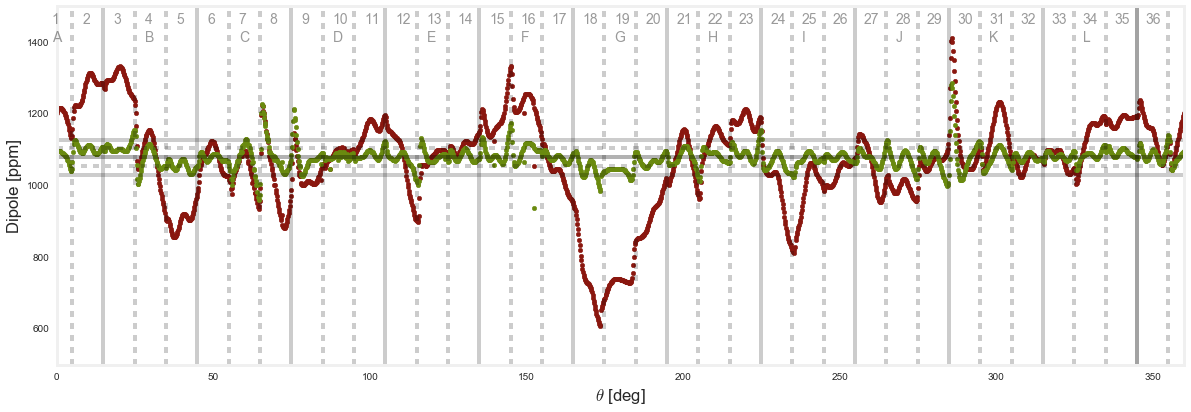

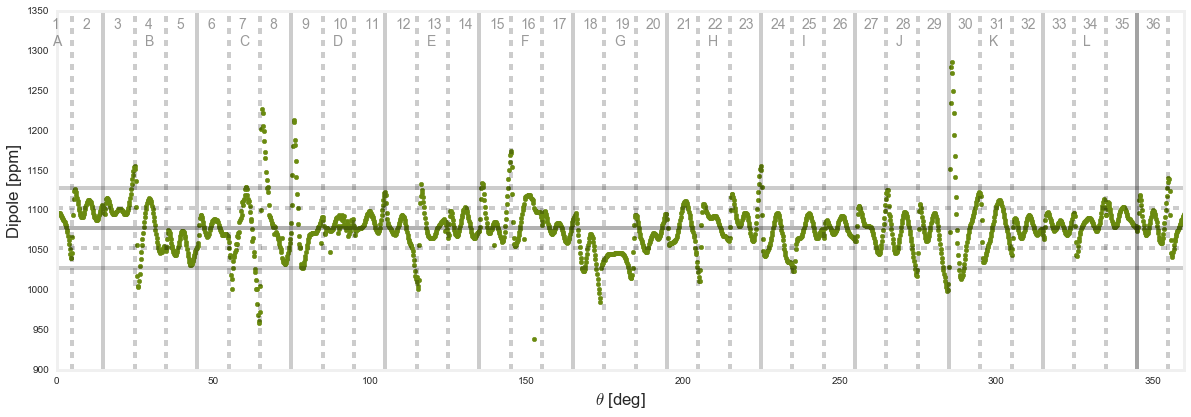

Current Normal Quadrupole avg: 1.774, std: 9.503
Optimal Normal Quadrupole avg: 0.019, std: 17.600


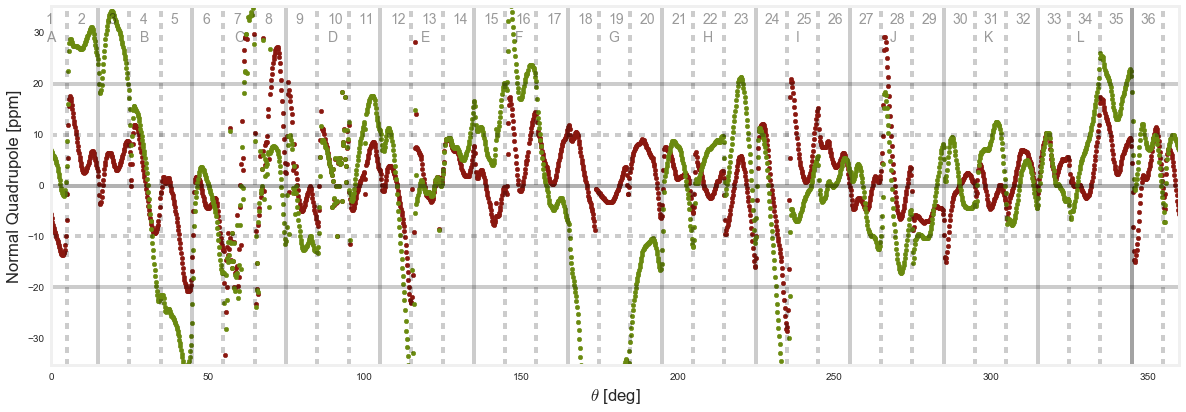

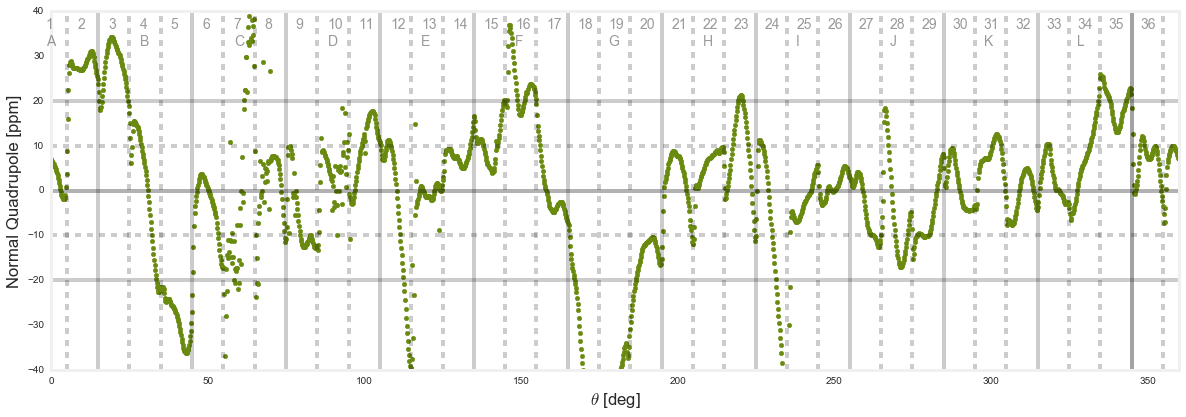

Current Skew Quadrupole avg: -1.787, std: 14.964
Optimal Skew Quadrupole avg: -1.787, std: 14.964


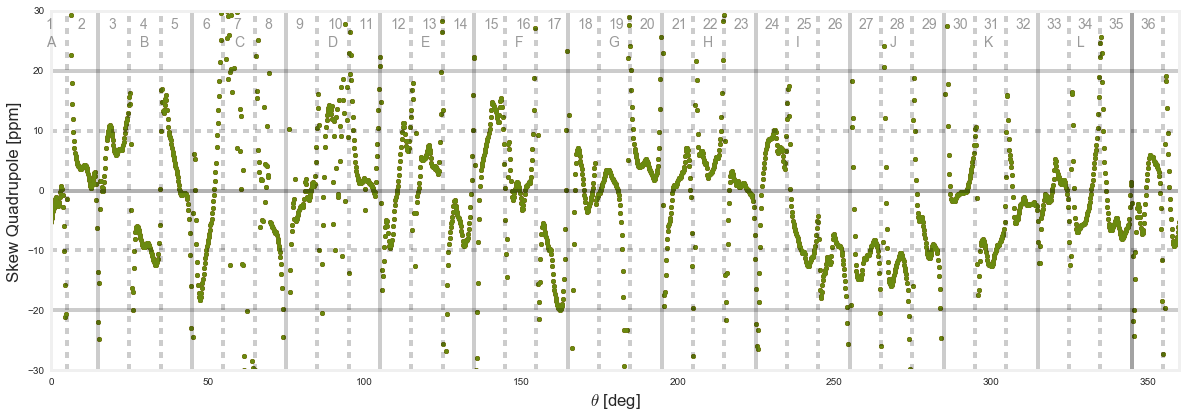

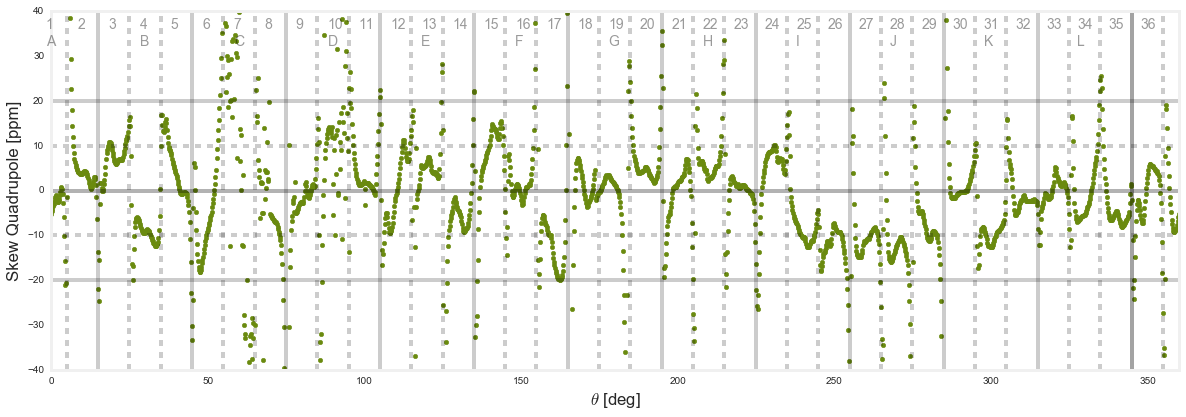

Current Normal Sextupole avg: -4.362, std: 8.118
Optimal Normal Sextupole avg: -4.362, std: 8.118


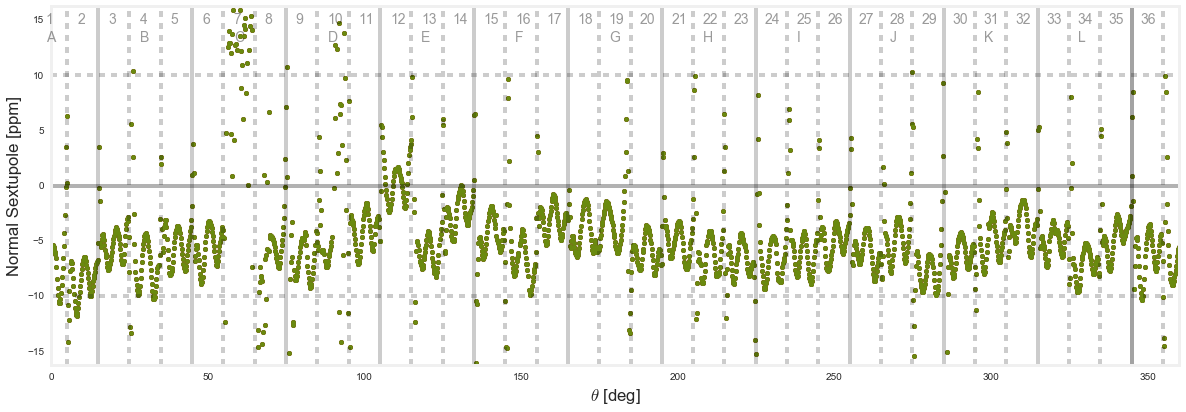

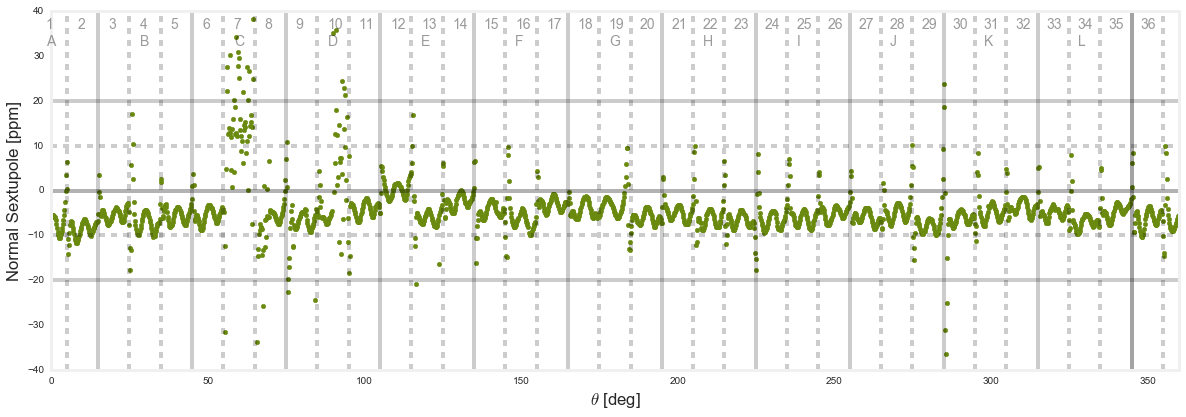

Current Skew Sextupole avg: -6.653, std: 9.606
Optimal Skew Sextupole avg: -6.653, std: 9.606


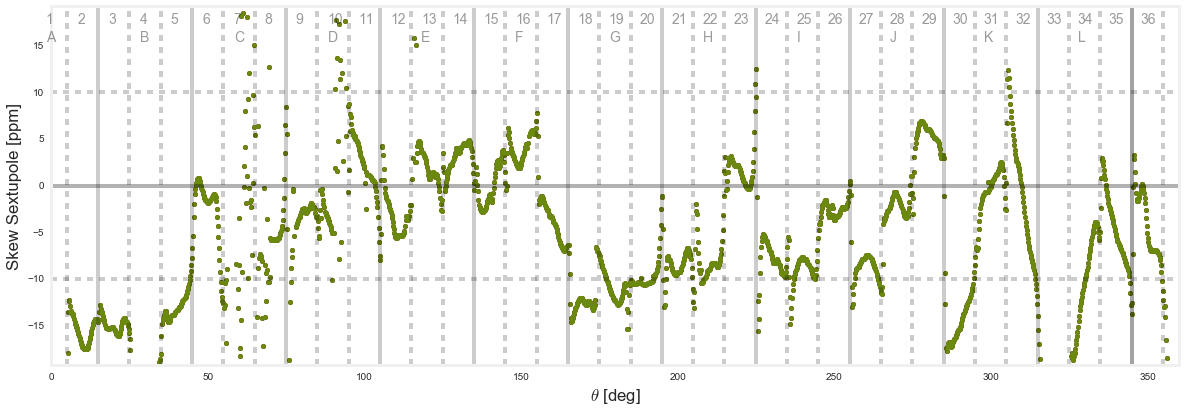

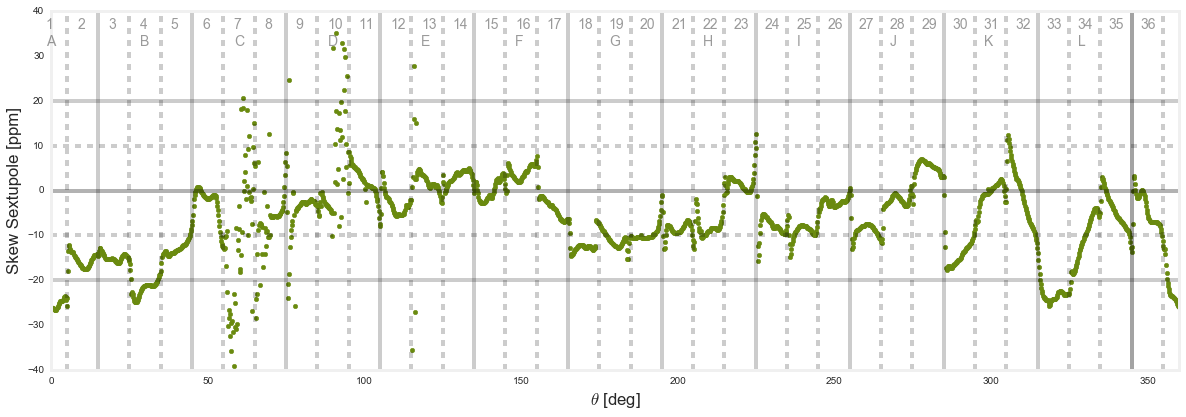

Current Normal Octupole avg: 0.628, std: 4.102
Optimal Normal Octupole avg: 0.628, std: 4.102


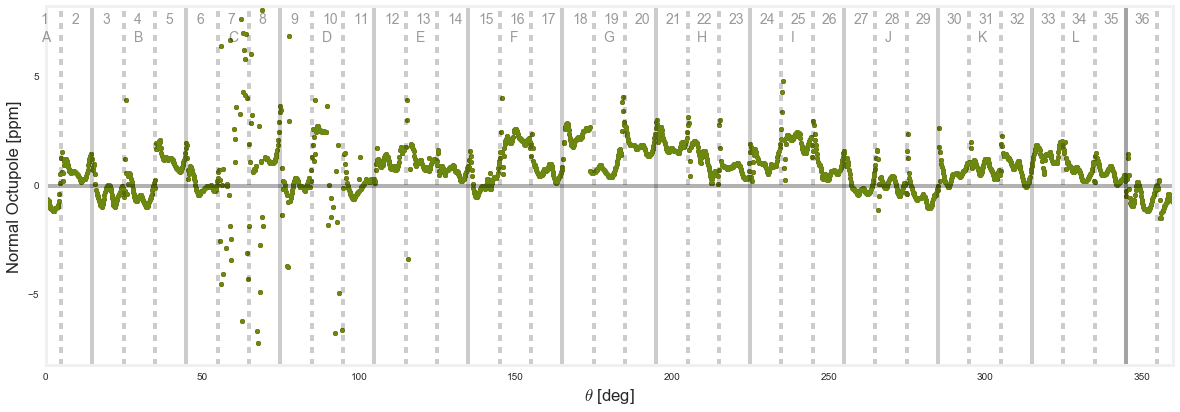

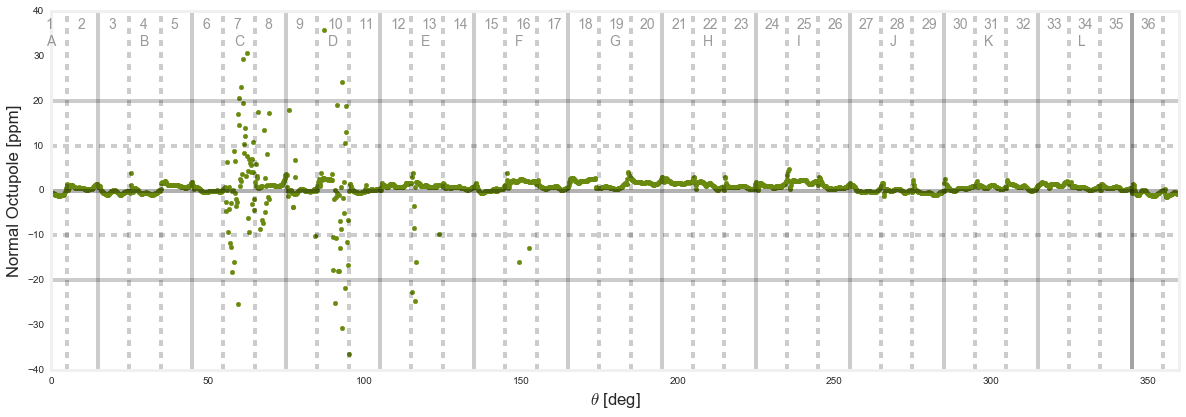

Current Skew Octupole avg: -0.627, std: 6.118
Optimal Skew Octupole avg: -0.627, std: 6.118


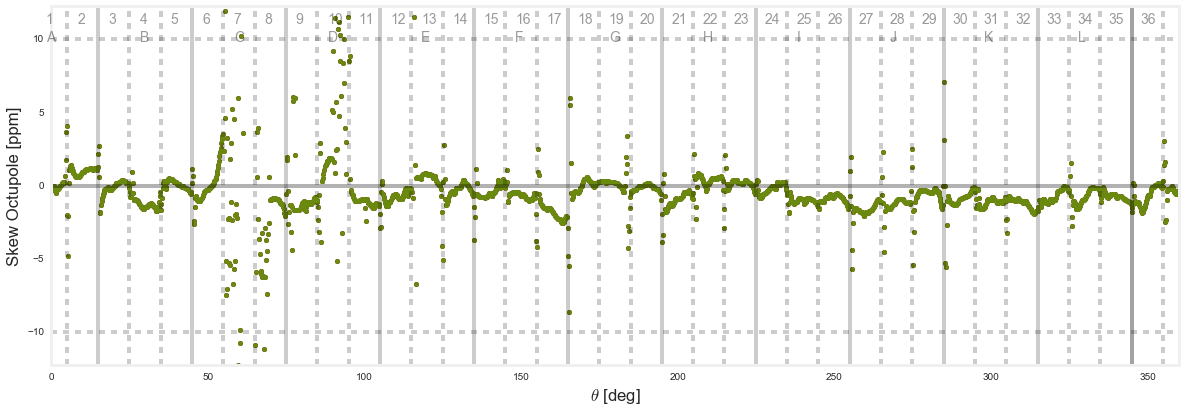

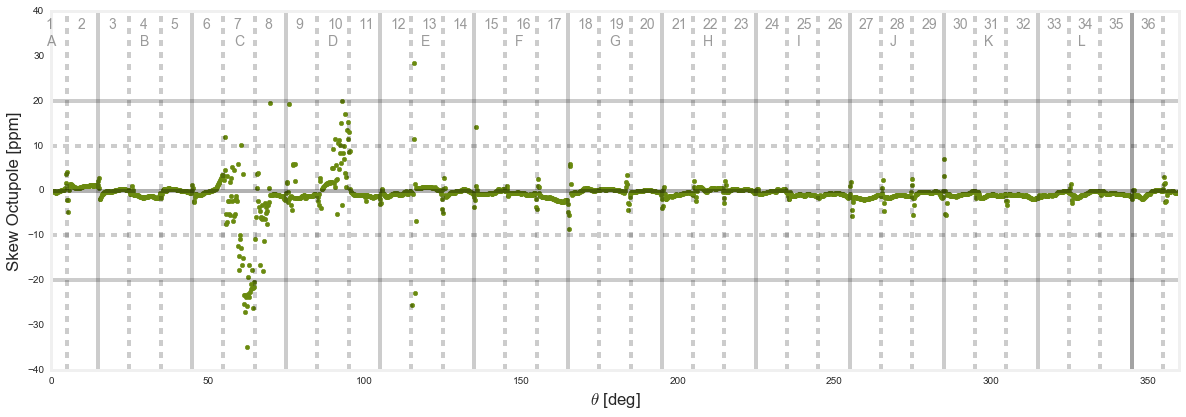

In [9]:
for i in xrange(num_mp):
    print "Current %s avg: %.3f, std: %.3f" % (mp_name[i], bfield[i].mean(), bfield[i].std())
    print "Optimal %s avg: %.3f, std: %.3f" % (mp_name[i], y_bfield[i].mean(), y_bfield[i].std())

    # Draw the multipole with target lines and original data.
    plt.scatter(phi, bfield[i], color=colors[0])
    plt.scatter(phi, y_bfield[i], color=colors[2])
    
    if i == 0:
        draw_targets(y_bfield[i].mean(), 25.0)

    else:
        draw_targets(0.0, 10.0)     
        plt.ylim([-2 * y_bfield[i].std(), 2 * y_bfield[i].std()])

    finish_plot(ylabel='%s [ppm]' % mp_name[i])
    
    # Draw the multipole with target lines alone.
    plt.scatter(phi, y_bfield[i], color=colors[2])
    
    if i == 0:
        draw_targets(y_bfield[i].mean(), 25.0)

    else:
        draw_targets(0.0, 10.0)     
        plt.ylim([-40, 40])

    finish_plot(ylabel='%s [ppm]' % mp_name[i])


### Field From Shims

I'm plotting the field change affected by the optimization model.  The top hats are in red, the wedges are in green and the eges are in blue.

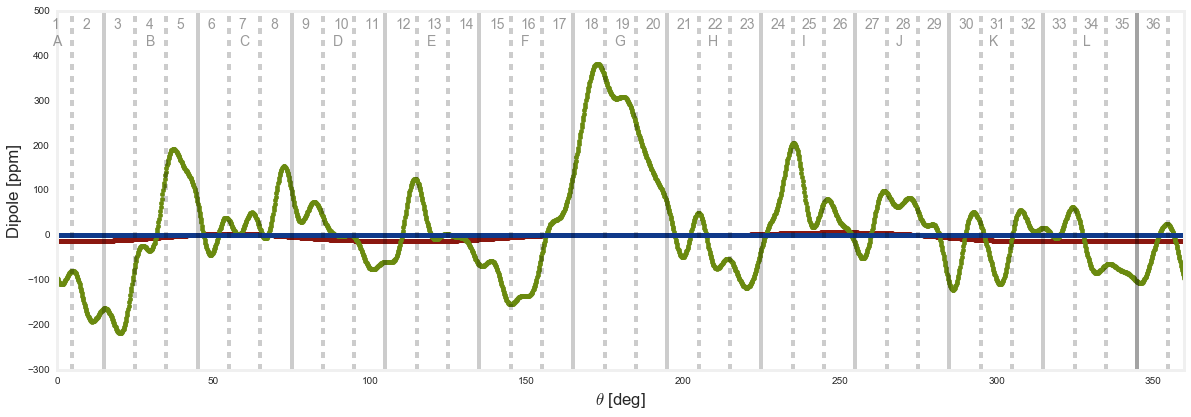

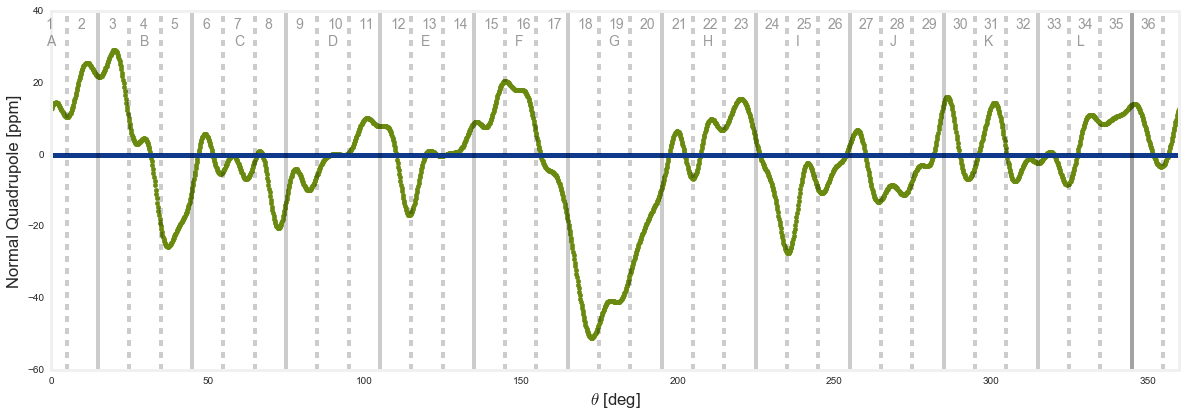

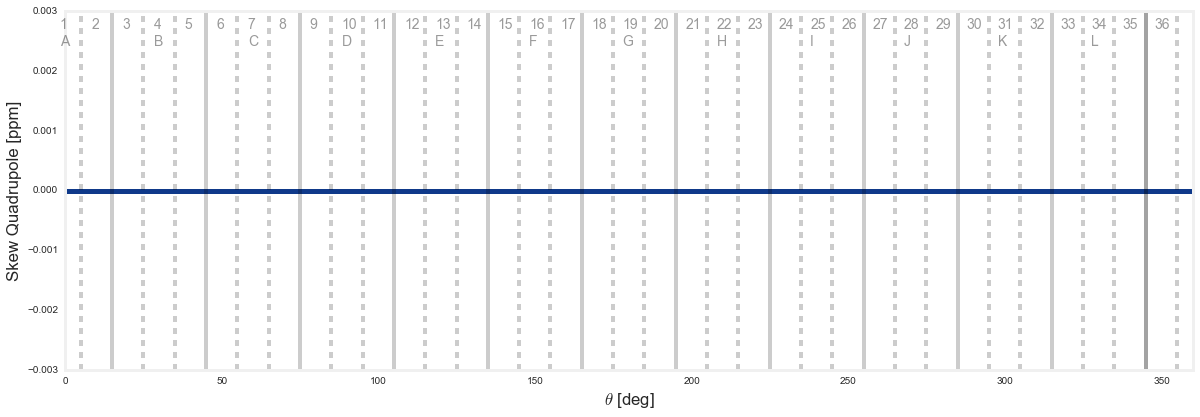

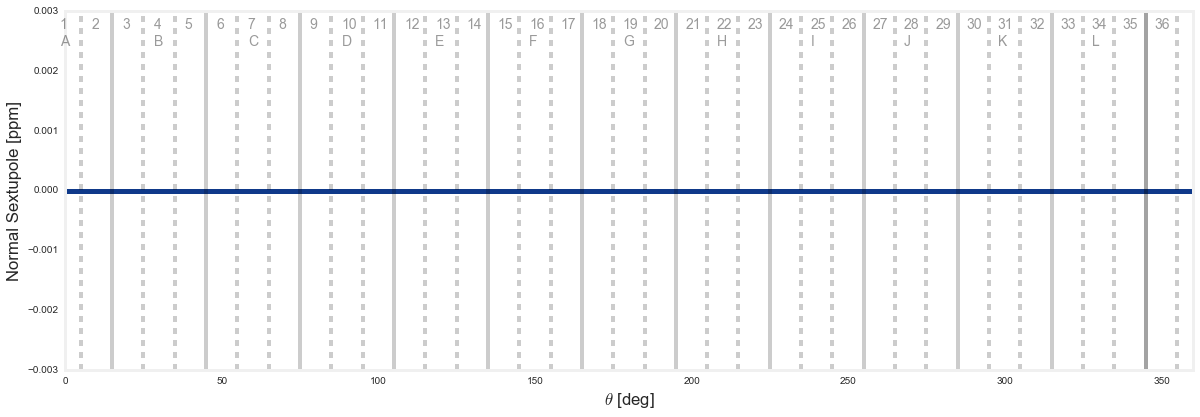

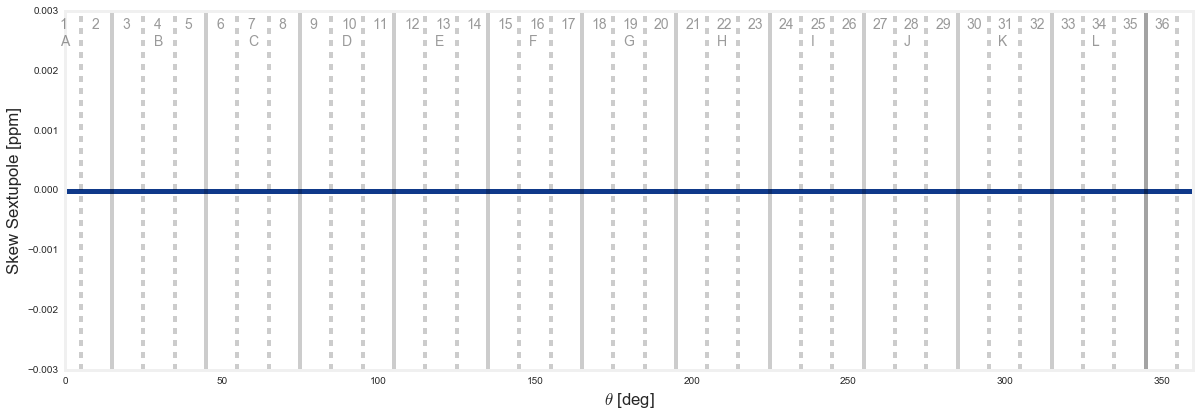

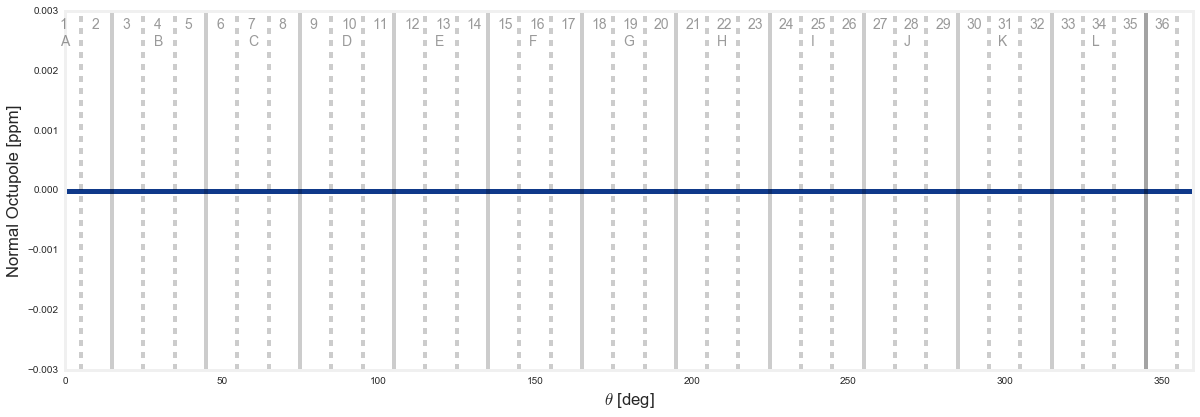

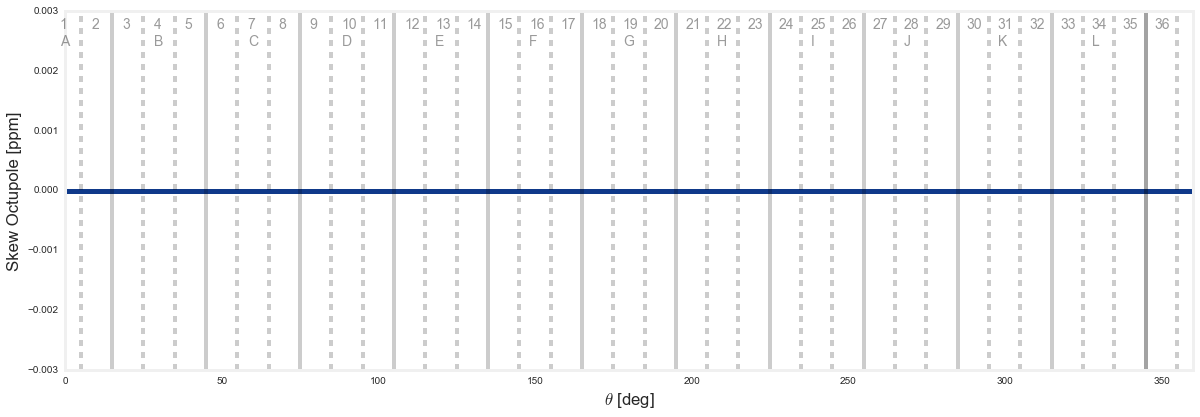

In [10]:
for i in xrange(num_mp):
    plt.scatter(phi, y_tophats[i], color=colors[0])
    plt.scatter(phi, y_wedges[i], color=colors[2])
    plt.scatter(phi, y_edges[i], color=colors[6])
    finish_plot(ylabel='%s [ppm]' % mp_name[i])

## Shim Positions

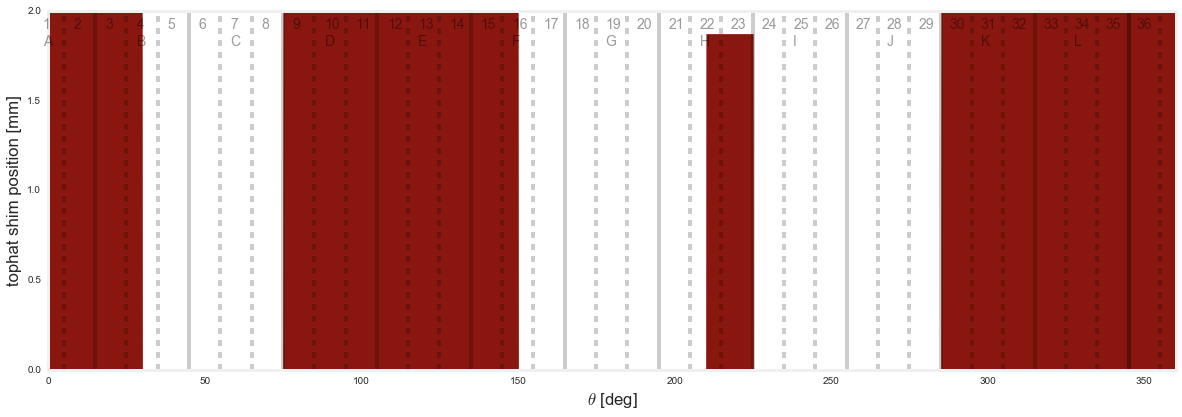

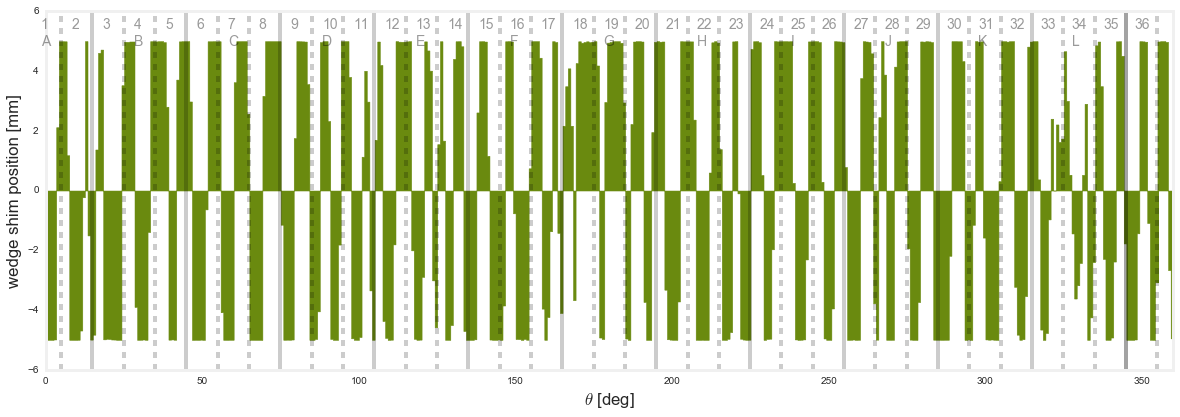

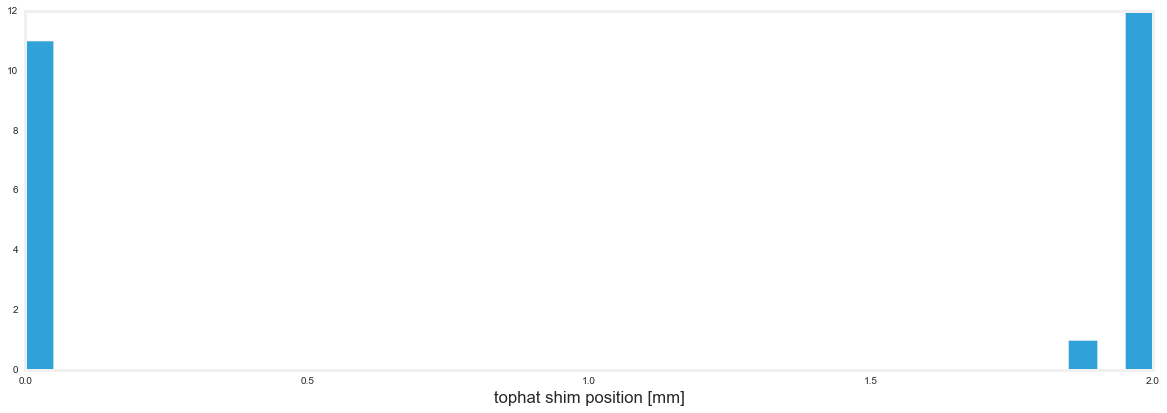

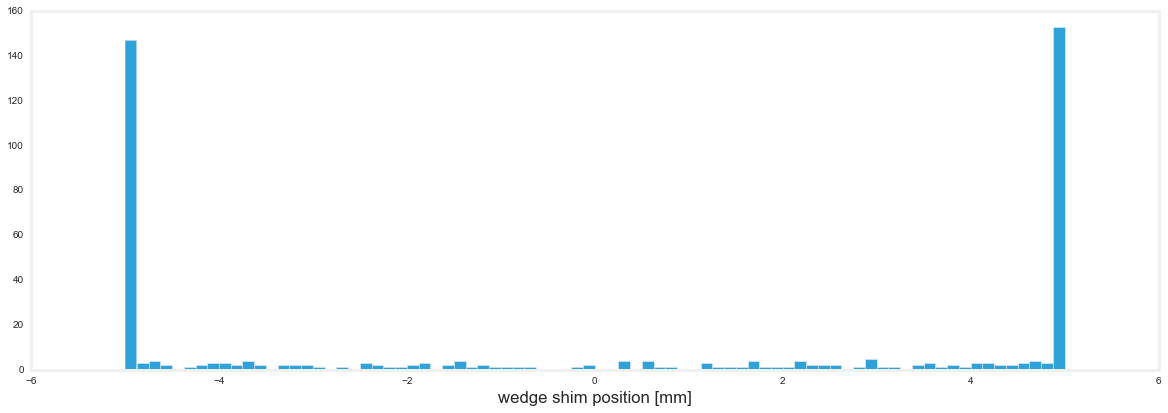

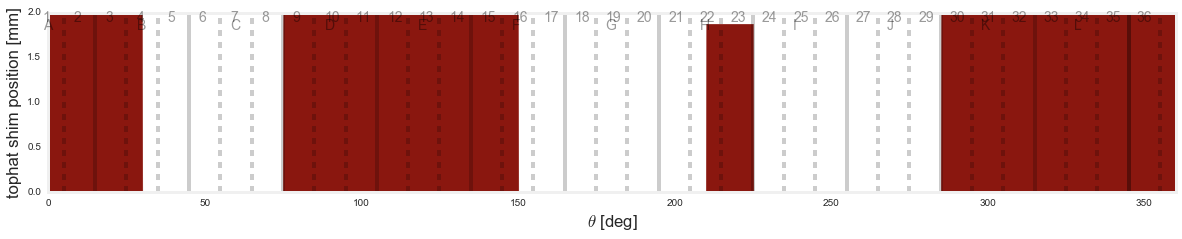

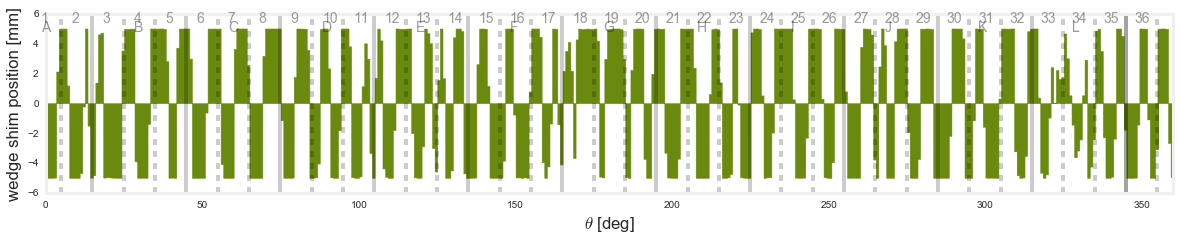

In [11]:
xtemp = x[1:num_tophats + 1]
y1 = np.empty(xtemp.shape[0] * 100)
for i in xrange(y1.shape[0]):
    y1[i] = xtemp[i / 100] + tophat_pos[i / 100]

x1 = np.linspace(-15.0, 345.0, num_tophats * 100) % 360.0
indices = x1.argsort()

plt.fill_between(x1[indices], y1[indices], color=colors[0])
finish_plot('tophat shim position [mm]')

xtemp = x[1 + num_tophats:1 + num_tophats + num_wedges]
y2 = np.empty(xtemp.shape[0] * 100)
for i in xrange(y2.shape[0]):
    y2[i] = xtemp[i / 100]

x2 = np.linspace(-5, 355, num_wedges * 100) % 360.0
indices = x2.argsort()
    
plt.fill_between(x2[indices], y2[indices], color=colors[2])
finish_plot('wedge shim position [mm]')

plt.hist(x[1:num_tophats + 1] + np.array(tophat_pos), bins=40)
plt.xlabel('tophat shim position [mm]')
plt.show()

plt.hist(x[1 + num_tophats:1 + num_tophats + num_wedges], bins=80)
plt.xlabel('wedge shim position [mm]')
plt.show()

mpl.rcParams['figure.figsize'] = (18, 3)
xtemp = x[1:num_tophats + 1]
y1 = np.empty(xtemp.shape[0] * 100)
for i in xrange(y1.shape[0]):
    y1[i] = xtemp[i / 100] + tophat_pos[i / 100]

x1 = np.linspace(-15.0, 345.0, num_tophats * 100) % 360.0
indices = x1.argsort()

plt.fill_between(x1[indices], y1[indices], color=colors[0])
finish_plot('tophat shim position [mm]')

xtemp = x[1 + num_tophats:1 + num_tophats + num_wedges]
y2 = np.empty(xtemp.shape[0] * 100)
for i in xrange(y2.shape[0]):
    y2[i] = xtemp[i / 100]

x2 = np.linspace(-5.0, 355.0, num_wedges * 100) % 360.0
indices = x2.argsort()
    
plt.fill_between(x2[indices], y2[indices], color=colors[2])
finish_plot('wedge shim position [mm]')

mpl.rcParams['figure.figsize'] = (18, 6)

## Shim Adjustment Plan

Based on the field optimization calculation the following changes to the shim positions are recommended.

In [12]:
display(Markdown('### Top Hat Changes'))

output = ['| Yoke %c | Top Hat 1 | Top Hat 2 |']
output.append('|-------------|------|------|')
output.append('| Change [mm] | %.2f | %.2f |')

tophat_delta = (x[1:1 + num_tophats]).reshape([num_tophats / 2, 2])

for i, d in enumerate(tophat_delta):
    display(Markdown('\n'.join(output) % tuple([ord('A') + i, d[0], d[1]])))

display(Markdown('### Top Hat Position'))
output = ['| Yoke %c | Top Hat 1 | Top Hat 2 |']
output.append('|-------------|------|------|')
output.append('| Height [mm] | %.2f | %.2f |')

tophat_delta = (x[1:1 + num_tophats] + np.array(tophat_pos)).reshape([num_tophats / 2, 2])

for i, d in enumerate(tophat_delta):
    display(Markdown('\n'.join(output) % tuple([ord('A') + i, d[0], d[1]])))

    
display(Markdown('### Wedge Shim Adjustments'))

output = ['| Pole %i | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |']
output.append('|----------|------|------|------|------|------|------|------|------|------|------|------|------|')
output.append('| Pos [mm] | %.2f | %.2f | %.2f | %.2f | %.2f | %.2f | %.2f | %.2f | %.2f | %.2f | %.2f | %.2f |')

wedge_delta = (x[1 + num_tophats:1 + num_wedges + num_tophats]).reshape([num_wedges / 12, 12])

for i, d in enumerate(wedge_delta):
    display(Markdown('\n'.join(output) % tuple([i + 1, d[0], d[1], d[2], d[3], d[4], d[5], d[6], d[7], d[8], d[9], d[10], d[11]])))

### Top Hat Changes

| Yoke A | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Change [mm] | 2.00 | 2.00 |

| Yoke B | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Change [mm] | 2.00 | 0.00 |

| Yoke C | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Change [mm] | -1.00 | -1.00 |

| Yoke D | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Change [mm] | 2.00 | 1.50 |

| Yoke E | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Change [mm] | 2.00 | 2.00 |

| Yoke F | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Change [mm] | 1.00 | -1.00 |

| Yoke G | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Change [mm] | 0.00 | 0.00 |

| Yoke H | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Change [mm] | 0.00 | 0.37 |

| Yoke I | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Change [mm] | -1.00 | -1.00 |

| Yoke J | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Change [mm] | -1.00 | -0.50 |

| Yoke K | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Change [mm] | 2.00 | 2.00 |

| Yoke L | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Change [mm] | 2.00 | 1.00 |

### Top Hat Position

| Yoke A | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Height [mm] | 2.00 | 2.00 |

| Yoke B | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Height [mm] | 2.00 | 0.00 |

| Yoke C | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Height [mm] | 0.00 | 0.00 |

| Yoke D | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Height [mm] | 2.00 | 2.00 |

| Yoke E | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Height [mm] | 2.00 | 2.00 |

| Yoke F | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Height [mm] | 2.00 | 0.00 |

| Yoke G | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Height [mm] | 0.00 | 0.00 |

| Yoke H | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Height [mm] | 0.00 | 1.87 |

| Yoke I | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Height [mm] | 0.00 | 0.00 |

| Yoke J | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Height [mm] | 0.00 | 0.00 |

| Yoke K | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Height [mm] | 2.00 | 2.00 |

| Yoke L | Top Hat 1 | Top Hat 2 |
|-------------|------|------|
| Height [mm] | 2.00 | 2.00 |

### Wedge Shim Adjustments

| Pole 1 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 4.99 | 5.00 | 5.00 | 4.97 | -2.67 | -4.95 | -5.00 | -5.00 | -5.00 | -4.99 | 2.12 | 5.00 |

| Pole 2 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 5.00 | 4.99 | 1.18 | -5.00 | -5.00 | -5.00 | -4.99 | -4.69 | -0.23 | 5.00 | -1.50 | -4.99 |

| Pole 3 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | -4.82 | 1.37 | 4.61 | 4.72 | -4.98 | -4.96 | -4.97 | -4.99 | -4.99 | -5.00 | -5.00 | 3.52 |

| Pole 4 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 4.98 | 4.98 | 4.99 | 4.99 | -3.90 | -5.00 | -4.99 | -4.99 | -5.00 | -1.39 | 5.00 | 5.00 |

| Pole 5 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 4.99 | 5.00 | 5.00 | 4.97 | 2.80 | -4.99 | -4.98 | -4.99 | 3.71 | 4.99 | 5.00 | 5.00 |

| Pole 6 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 5.00 | 2.98 | -5.00 | -5.00 | -5.00 | -4.99 | -5.00 | -0.63 | 4.99 | 4.99 | 5.00 | 4.99 |

| Pole 7 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 5.00 | -4.07 | -5.00 | -5.00 | -5.00 | -5.00 | 3.62 | 5.00 | 5.00 | 5.00 | 5.00 | 2.57 |

| Pole 8 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | -5.00 | -5.00 | -5.00 | -5.00 | -5.00 | 3.17 | 5.00 | 5.00 | 5.00 | 5.00 | 5.00 | 5.00 |

| Pole 9 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | -1.14 | -5.00 | -4.99 | -4.99 | -4.99 | 1.76 | 5.00 | 5.00 | 4.99 | 4.99 | 3.56 | -5.00 |

| Pole 10 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | -5.00 | -4.97 | -4.04 | 4.97 | 5.00 | 5.00 | 2.33 | -4.97 | -5.00 | -5.00 | -1.81 | 5.00 |

| Pole 11 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 5.00 | 5.00 | 3.80 | -4.95 | -5.00 | -5.00 | -4.90 | 1.13 | 4.01 | 2.98 | -3.34 | -5.00 |

| Pole 12 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 1.70 | 4.99 | 4.20 | -4.37 | -4.93 | -5.00 | -4.99 | -1.80 | 5.00 | 4.98 | 4.98 | 4.98 |

| Pole 13 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 4.99 | 5.00 | -2.00 | -4.96 | -5.00 | -4.99 | -2.89 | 4.99 | 4.69 | 4.01 | -3.01 | -4.58 |

| Pole 14 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 1.55 | 5.00 | 1.67 | -5.00 | -5.00 | -4.50 | 4.41 | 4.99 | 5.00 | 4.83 | -4.70 | -5.00 |

| Pole 15 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | -5.00 | -5.00 | -4.98 | 2.61 | 5.00 | 5.00 | 4.99 | 1.16 | -4.99 | -5.00 | -5.00 | -4.99 |

| Pole 16 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | -5.00 | -3.85 | 4.99 | 5.00 | 4.99 | -0.76 | -4.97 | -4.97 | -5.00 | -4.97 | -4.99 | 0.74 |

| Pole 17 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 5.00 | 5.00 | 5.00 | 4.44 | -3.95 | -5.00 | -4.23 | -1.36 | 5.00 | 4.97 | -1.42 | -4.10 |

| Pole 18 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 2.17 | 3.49 | 4.09 | 2.17 | -3.67 | 4.27 | 4.99 | 4.95 | 4.97 | 4.99 | 4.97 | 4.98 |

| Pole 19 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 5.00 | 4.18 | -4.92 | -4.97 | 2.96 | 4.95 | 4.97 | 5.00 | 5.00 | 5.00 | 4.94 | 2.95 |

| Pole 20 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | -4.95 | -5.00 | 2.23 | 4.99 | 5.00 | 5.00 | 4.99 | -3.73 | -5.00 | -5.00 | 1.96 | 4.98 |

| Pole 21 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 5.00 | 4.98 | 4.99 | -3.32 | -4.98 | -4.99 | -5.00 | -5.00 | -3.71 | 5.00 | 4.99 | 4.99 |

| Pole 22 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 4.99 | 4.99 | 2.37 | -5.00 | -5.00 | -4.99 | -5.00 | -5.00 | 0.60 | 4.96 | 5.00 | 4.95 |

| Pole 23 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 1.39 | -5.00 | -5.00 | -4.96 | -4.74 | 4.99 | 5.00 | -0.10 | -4.96 | -4.99 | -5.00 | -4.99 |

| Pole 24 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 4.74 | 5.00 | 5.00 | 4.96 | 0.52 | -5.00 | -4.97 | -4.96 | -1.97 | 5.00 | 4.99 | 5.00 |

| Pole 25 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 5.00 | 5.00 | 4.99 | 5.00 | 0.26 | -4.98 | -5.00 | -4.99 | -4.98 | -2.31 | 4.99 | 4.99 |

| Pole 26 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 5.00 | 5.00 | 4.97 | 0.29 | -4.95 | -5.00 | -5.00 | -3.95 | 5.00 | 4.99 | 4.99 | 4.97 |

| Pole 27 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 0.79 | -5.00 | -5.00 | -4.99 | -5.00 | -5.00 | 3.76 | 5.00 | 4.99 | 4.97 | 4.59 | -3.78 |

| Pole 28 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | -4.99 | 2.46 | 5.00 | 3.88 | -5.00 | -5.00 | -5.00 | 4.15 | 4.99 | 5.00 | 5.00 | 5.00 |

| Pole 29 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | -1.94 | -4.99 | -5.00 | -5.00 | -3.73 | 4.99 | 4.98 | 5.00 | 4.99 | 4.97 | -4.99 | -4.99 |

| Pole 30 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | -5.00 | -5.00 | -5.00 | -4.99 | -2.18 | 5.00 | 5.00 | 5.00 | 4.99 | 4.33 | -5.00 | -4.99 |

| Pole 31 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | -5.00 | -1.15 | 5.00 | 4.98 | 4.99 | -1.58 | -4.98 | -4.99 | -4.99 | -5.00 | -5.00 | 0.31 |

| Pole 32 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 5.00 | 5.00 | 4.98 | 5.00 | 5.00 | -3.22 | -4.82 | -5.00 | -4.97 | -3.53 | 4.82 | 4.99 |

| Pole 33 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 5.00 | 5.00 | 0.37 | -4.65 | -5.00 | -4.77 | -0.97 | 2.40 | -0.00 | 2.21 | 1.63 | 1.74 |

| Pole 34 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 4.66 | 3.00 | 0.53 | -1.44 | -3.62 | -3.17 | -2.43 | 0.52 | 2.90 | -5.00 | -4.25 | -2.40 |

| Pole 35 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | 4.86 | 4.99 | 3.49 | -2.29 | -5.00 | -5.00 | -4.92 | -2.38 | 4.99 | 5.00 | 4.51 | -1.77 |

| Pole 36 | W-01 | W-02 | W-03 | W-04 | W-05 | W-06 | W-07 | W-08 | W-09 | W-10 | W-11 | W-12 |
|----------|------|------|------|------|------|------|------|------|------|------|------|------|
| Pos [mm] | -5.00 | -5.00 | -5.00 | -4.99 | -1.43 | 5.00 | 4.99 | 4.98 | -1.09 | -5.00 | -5.00 | -3.07 |